# PyTorch DNN model

In this notebook, we build a deep neural network (DNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Project imports
from functions.evaluation import evaluate_model
from functions.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 2500 # Images come in batches of 10,000 already
learning_rate = 3e-3
epochs = 150
print_every = 10 # Print training progress every n epochs

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. We convert the images to grayscale for this demonstration.

### 1.1. Define transformations

In [3]:
# Define class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Data preprocessing: convert to grayscale, tensor, and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 1.2. Load datasets

In [4]:
# Make sure data directory exists
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.3. Pre-load data and create data loaders

In [5]:
# Pre-load entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


In [6]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 16
Validation batches: 4
Test batches: 4


### 1.4. Visualize sample images

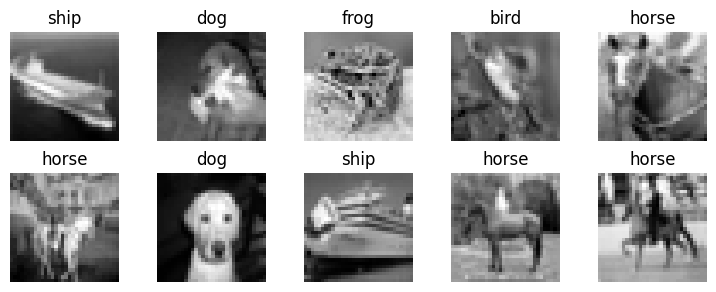

In [7]:
# Get a batch of training images
images, labels = next(iter(train_loader))

# Plot first 10 images
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):

    # Unnormalize and squeeze for plotting (move to CPU first)
    img = images[i].cpu() * 0.5 + 0.5
    img = img.numpy().squeeze()
    ax.set_title(class_names[labels[i]])
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. Build DNN classifier with nn.Sequential

We build a fully connected deep neural network using `nn.Sequential`. Since we are not using convolutional layers, we flatten the 32x32x1 grayscale images into a 1024-dimensional vector.

### 2.1. Define model architecture

In [15]:
# Input size: 32 x 32 x 1 = 1024 (grayscale)
input_size = 32 * 32 * 1
num_classes = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(input_size, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=1024, out_features=256, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=256, out_features=64, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 1329098


### 2.2. Define loss function and optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [17]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/150 - loss: 2.1677 - accuracy: 20.30% - val_loss: 2.0169 - val_accuracy: 28.17%
Epoch 10/150 - loss: 1.8364 - accuracy: 35.49% - val_loss: 1.7311 - val_accuracy: 39.17%
Epoch 20/150 - loss: 1.7512 - accuracy: 38.45% - val_loss: 1.6559 - val_accuracy: 40.75%
Epoch 30/150 - loss: 1.7033 - accuracy: 40.07% - val_loss: 1.6016 - val_accuracy: 43.11%
Epoch 40/150 - loss: 1.6639 - accuracy: 41.77% - val_loss: 1.5813 - val_accuracy: 43.34%
Epoch 50/150 - loss: 1.6344 - accuracy: 42.19% - val_loss: 1.5699 - val_accuracy: 44.58%
Epoch 60/150 - loss: 1.6096 - accuracy: 43.82% - val_loss: 1.5372 - val_accuracy: 45.26%
Epoch 70/150 - loss: 1.5944 - accuracy: 44.53% - val_loss: 1.5299 - val_accuracy: 45.66%
Epoch 80/150 - loss: 1.5769 - accuracy: 44.95% - val_loss: 1.5310 - val_accuracy: 45.60%
Epoch 90/150 - loss: 1.5623 - accuracy: 45.20% - val_loss: 1.5112 - val_accuracy: 47.02%
Epoch 100/150 - loss: 1.5582 - accuracy: 45.41% - val_loss: 1.5123 - val_accuracy: 46.50%
Epoch 110/150 - loss:

### 2.5. Learning curves

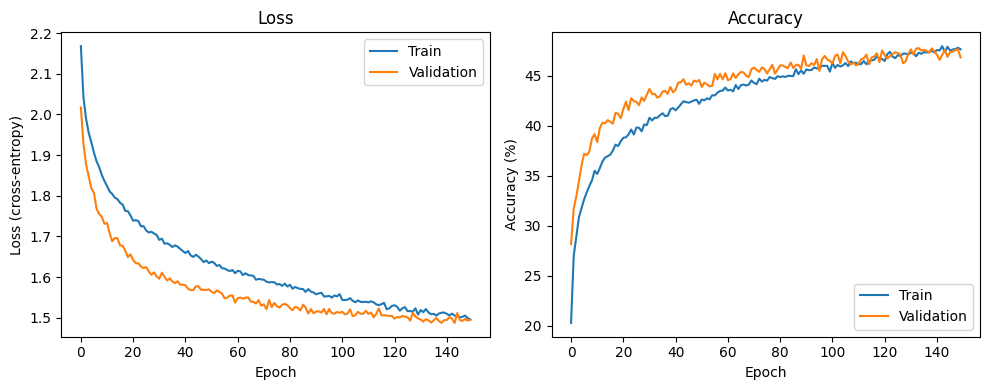

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss')
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy')
axes[1].plot(history['train_accuracy'], label='Train')
axes[1].plot(history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [19]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 47.46%


### 3.2. Per-class accuracy

In [20]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 38.40%
automobile  : 53.10%
bird        : 32.50%
cat         : 31.60%
deer        : 50.40%
dog         : 33.90%
frog        : 57.80%
horse       : 53.40%
ship        : 73.30%
truck       : 50.20%


### 3.4. Confusion matrix

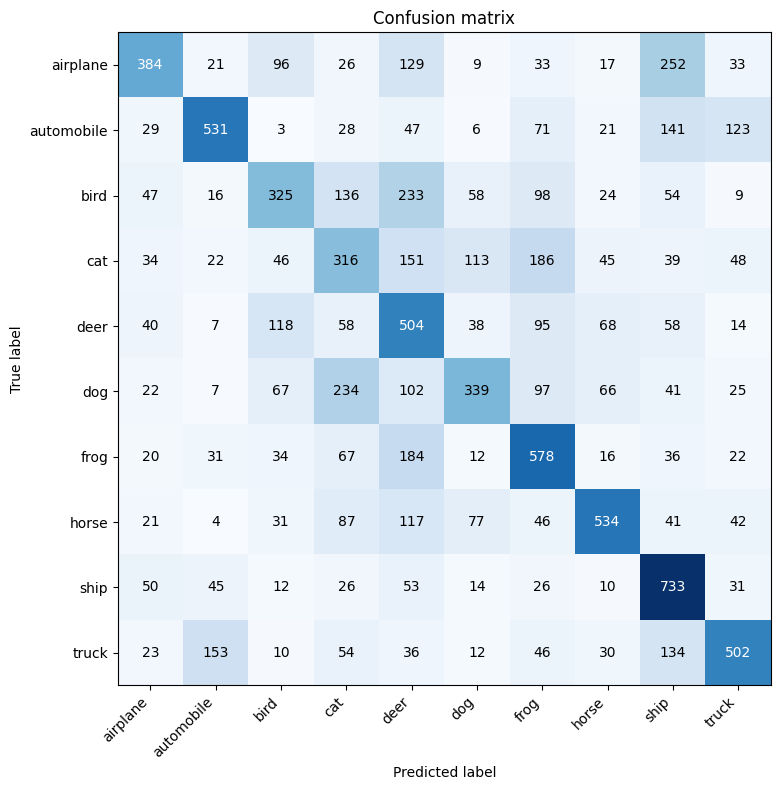

In [21]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title('Confusion matrix')
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add text annotations
for i in range(len(class_names)):

    for j in range(len(class_names)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color=color)

plt.tight_layout()
plt.show()